# Project 1

[1] loss: 4.192


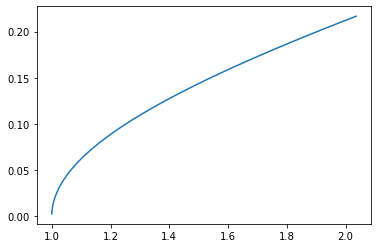

[2] loss: 1.981


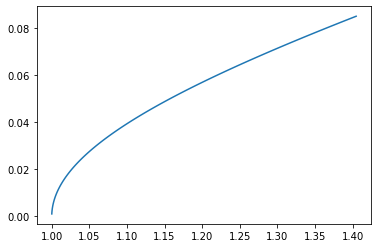

[3] loss: 0.987


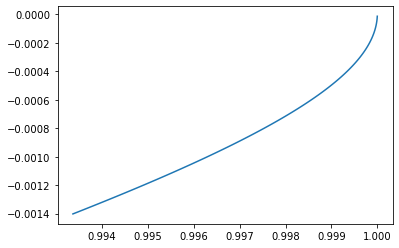

[4] loss: 0.537


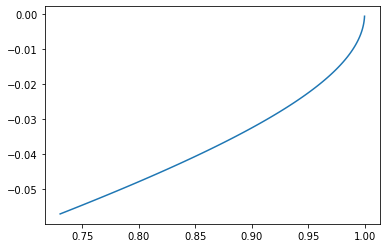

[5] loss: 0.315


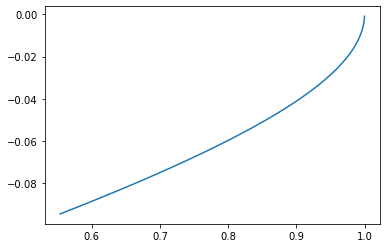

[6] loss: 0.199


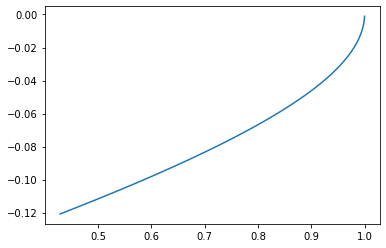

[7] loss: 0.134


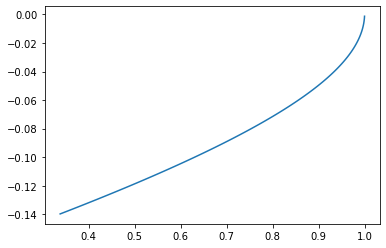

[8] loss: 0.097


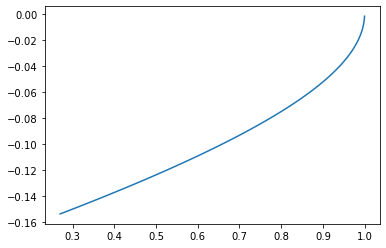

[9] loss: 0.075


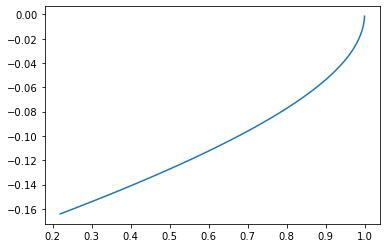

[10] loss: 0.062


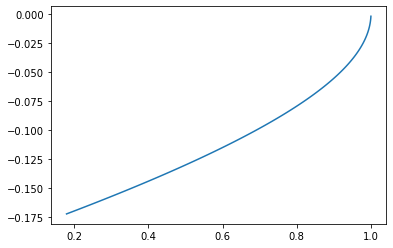

[11] loss: 0.054


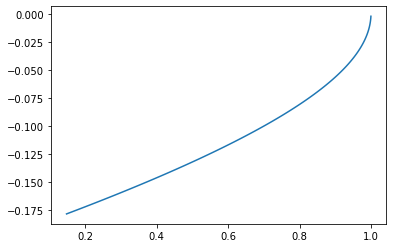

[12] loss: 0.049


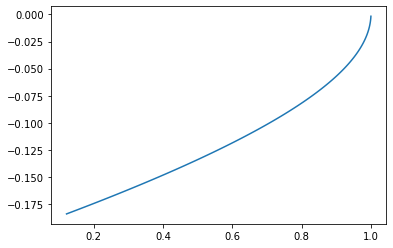

[13] loss: 0.046


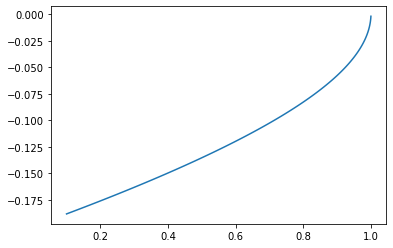

[14] loss: 0.044


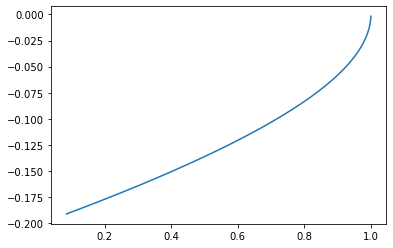

[15] loss: 0.043


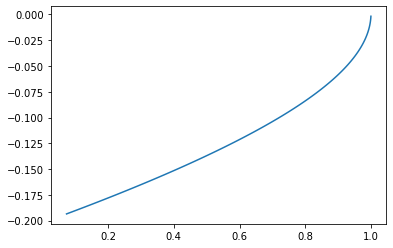

[16] loss: 0.042


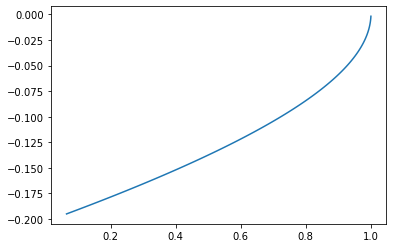

[17] loss: 0.042


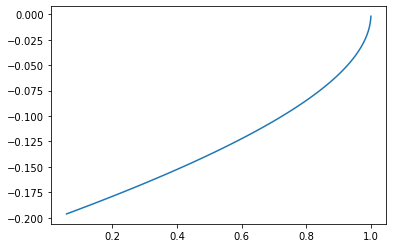

[18] loss: 0.042


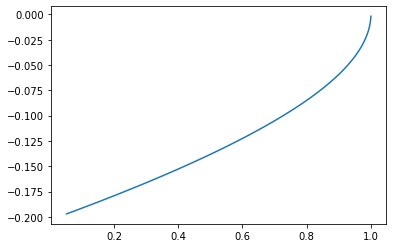

[19] loss: 0.041


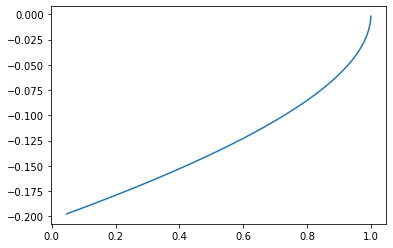

[20] loss: 0.041


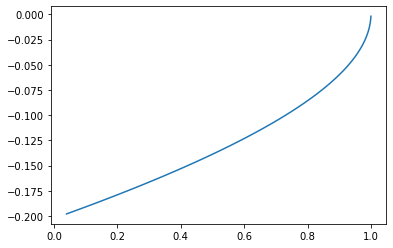

In [ ]:
# MAE 598 Design Optimization - Project # 1
# Benjamin Webb
# 10/21/2022

# Import required libraries
import logging
#import math
#import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
#from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define global parameters
FRAME_TIME = np.single(0.1)         # time inteval
GRAVITY_ACCEL = np.single(0.12)     # gravitaional acceleration parameter
BOOST_ACCEL = np.single(0.18)       # Trust accelleration parameter

# Define Class for system dynamics
class Dynamics(nn.Module):

	# Initialize class
	def __init__(self):
		super(Dynamics, self).__init__()

	@staticmethod
	def forward(state, action):

		# action: thrust or no thrust

		# Apply gravitational acceleration
		delta_gravity = torch.tensor([0.0, GRAVITY_ACCEL * FRAME_TIME], dtype=torch.float)

		# Apply thrust
		delta_thrust = BOOST_ACCEL * FRAME_TIME * torch.tensor([0.0, -1.0], dtype=torch.float) * action

		# Update velocity
		state = state + delta_thrust + delta_gravity

		# Update state vector
		step_mat = torch.tensor([[1.0, FRAME_TIME],
		                        [0.0, 1.0]], dtype=torch.float)
		state = torch.matmul(step_mat, state)

		return state

# Define Controller Class
class Controller(nn.Module):

	# Initialize class
	def __init__(self, dim_input, dim_hidden, dim_output):
		# dim_input: # of system states
		# dim_output: # of actions
		# dim_hidden: TBD

		super(Controller, self).__init__()
		self.network = nn.Sequential(nn.Linear(dim_input, dim_hidden),
		                             nn.Tanh(), nn.Linear(dim_hidden, dim_output),
		                             nn.Sigmoid())

	# define Controller forward method
	def forward(self, state):
		action = self.network(state)
		return action

# Define Simulation Class
class Simulation(nn.Module):

	# Initialize Class
	def __init__(self, controller, dynamics, T):
		super(Simulation, self).__init__()
		self.state = self.intialize_state()
		self.controller = controller
		self.dynamics = dynamics
		self.T = T
		self.action_trajectory = []
		self.state_trajectory = []

	# Define Simulation class forward method
	def forward(self, state):
		self.action_trajectory = []
		self.state_trajectory = []
		for _ in range(self.T):
			action = self.controller.forward(state)
			state = self.dynamics.forward(state, action)
			self.action_trajectory.append(action)
			self.state_trajectory.append(state)

		return self.error(state)

	@staticmethod
	def intialize_state():
		state = np.array([1.0, 0.0], dtype=np.single)          # Need to update

		return torch.tensor(data=state, dtype=torch.float, requires_grad=False)

	# Define Simulation class error, will need to be updated for increased state variables
	@staticmethod
	def error(state):
		return state[0]**2 + state[1]**2

# Define Optimizer class. Currently, using LBFGS
class Optimize:

	# Initialize class
	def __init__(self, simulation):
		super(Optimize, self).__init__()
		self.simulation = simulation
		self.parameters = simulation.controller.parameters()
		self.optimizer = optim.LBFGS(self.parameters, lr=0.01)      # Current learning rate at 0.01

	# Define Optmize class step function
	def step(self):
		# Define Closure function so gradient can be calculated multiple times
		def closure():
			loss = self.simulation(self.simulation.state)
			self.optimizer.zero_grad()
			loss.backward()

			return loss

		# Possible reccursive operation
		self.optimizer.step(closure)

		return closure()

	# Define Optimize class train function
	def train(self, epochs):
		for epoch in range(epochs):
			loss = self.step()
			print('[%d] loss: %.3f' % (epoch + 1, loss))
			self.visualize()                                # Will update later

	# Define Optimize class visulize function, will be updated later
	def visualize(self):
		data = np.zeros((self.simulation.T, 2), dtype=np.single)
		for i in range(self.simulation.T):
			temp = self.simulation.state_trajectory[i].detach()
			data[i, :] = temp.numpy()

		x = data[:, 0]
		y = data[:, 1]
		plt.plot(x, y)
		plt.show()

# Define main program script
if __name__ == '__main__':

	# Begin timer
	start_time = time.time()

	# Initial test to ensure code is working
	T = 100             # number of time steps
	dim_input = 2       # number of state-space variables, currently 2, will be expanded to 4
	dim_hidden = 6      # depth of neurnal network
	dim_output = 1      # number of actions, currently 1, will be expanded to 2

	d = Dynamics()                                      # Created Dynamics class object
	c = Controller(dim_input, dim_hidden, dim_output)   # Created Controller class object
	s = Simulation(controller=c, dynamics=d, T=T)       # Created Simulation class object
	o = Optimize(simulation=s)                          # Created Optimizer Class object
	o.train(epochs=40)                                  # Test code

	# End timer
	end_time = time.time()

	# Print program execution time
	total_time = end_time - start_time
	print('Execution Time:', total_time, 'seconds')
